# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=30,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_12-44-19/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4689 | MulticlassF1Score=0.0896
Batch-30 : CrossEntropyLoss=2.4780 | MulticlassF1Score=0.1747
Batch-45 : CrossEntropyLoss=2.4818 | MulticlassF1Score=0.2001
Batch-60 : CrossEntropyLoss=2.4672 | MulticlassF1Score=0.2158
Batch-75 : CrossEntropyLoss=2.4666 | MulticlassF1Score=0.2287
Batch-90 : CrossEntropyLoss=2.4766 | MulticlassF1Score=0.2484
Batch-105: CrossEntropyLoss=2.4498 | MulticlassF1Score=0.2701
Batch-120: CrossEntropyLoss=2.4226 | MulticlassF1Score=0.2875
Batch-135: CrossEntropyLoss=2.4235 | MulticlassF1Score=0.3082
Batch-150: CrossEntropyLoss=2.3986 | MulticlassF1Score=0.3239
Batch-165: CrossEntropyLoss=2.4311 | MulticlassF1Score=0.3379
Batch-180: CrossEntropyLoss=2.3813 | MulticlassF1Score=0.3507
Batch-195: CrossEntropyLoss=2.3880 | MulticlassF1Score=0.3663
Batch-210: CrossEntropyLoss=2.3664 | MulticlassF1Score=0.3840
Batch-225: CrossEntropyLoss=2.3447 | MulticlassF1Score=0.4048
Batch-226: CrossEntropyLoss=2.3293 | MulticlassF1Score=0.4057

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3340 | MulticlassF1Score=0.6950
Batch-30 : CrossEntropyLoss=2.3341 | MulticlassF1Score=0.6973
Batch-45 : CrossEntropyLoss=2.3435 | MulticlassF1Score=0.6969
Batch-60 : CrossEntropyLoss=2.3459 | MulticlassF1Score=0.6977
Batch-63 : CrossEntropyLoss=2.3304 | MulticlassF1Score=0.6992

Training   : Mean CrossEntropyLoss = 2.4432 | Mean MulticlassF1Score = 0.2692
Validation : Mean CrossEntropyLoss = 2.3438 | Mean MulticlassF1Score = 0.6954

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3408 | MulticlassF1Score=0.7117
Batch-30 : CrossEntropyLoss=2.3345 | MulticlassF1Score=0.7127
Batch-45 : CrossEntropyLoss=2.3228 | MulticlassF1Score=0.7154
Batch-60 : CrossEntropyLoss=2.3270 | MulticlassF1Score=0.7149
Batch-75 : CrossEntropyLoss=2.3200 | MulticlassF1Score=0.7165
Batch-90 : CrossEntropyLoss=2.3538 | MulticlassF1Score=0.7164
Batch-105: CrossEntropyLoss=2.3476 | MulticlassF1Score=0.7165
Batch-120: CrossEntropyLoss=2.3319 | MulticlassF1Score=0.7157
Batch-135: CrossEntropyLoss=2.3431 | MulticlassF1Score=0.7163
Batch-150: CrossEntropyLoss=2.3402 | MulticlassF1Score=0.7157
Batch-165: CrossEntropyLoss=2.3501 | MulticlassF1Score=0.7170
Batch-180: CrossEntropyLoss=2.3293 | MulticlassF1Score=0.7173
Batch-195: CrossEntropyLoss=2.3277 | MulticlassF1Score=0.7183
Batch-210: CrossEntropyLoss=2.3253 | MulticlassF1Score=0.7187
Batch-225: CrossEntropyLoss=2.3143 | MulticlassF1Score=0.7215
Batch-226: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7217

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.7876
Batch-30 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7858
Batch-45 : CrossEntropyLoss=2.3282 | MulticlassF1Score=0.7825
Batch-60 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7805
Batch-63 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7798

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3348 | Mean MulticlassF1Score = 0.7161
Validation : Mean CrossEntropyLoss = 2.3177 | Mean MulticlassF1Score = 0.7844

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7835
Batch-30 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7842
Batch-45 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.7870
Batch-60 : CrossEntropyLoss=2.3166 | MulticlassF1Score=0.7884
Batch-75 : CrossEntropyLoss=2.3212 | MulticlassF1Score=0.7882
Batch-90 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.7898
Batch-105: CrossEntropyLoss=2.3108 | MulticlassF1Score=0.7909
Batch-120: CrossEntropyLoss=2.3194 | MulticlassF1Score=0.7912
Batch-135: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7916
Batch-150: CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7914
Batch-165: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.7927
Batch-180: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.7941
Batch-195: CrossEntropyLoss=2.3139 | MulticlassF1Score=0.7940
Batch-210: CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7944
Batch-225: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7953
Batch-226: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.7953

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3218 | MulticlassF1Score=0.8015
Batch-30 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.7993
Batch-45 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8000
Batch-60 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8004
Batch-63 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8010

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3116 | Mean MulticlassF1Score = 0.7900
Validation : Mean CrossEntropyLoss = 2.3097 | Mean MulticlassF1Score = 0.8013

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7984
Batch-30 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.7980
Batch-45 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8008
Batch-60 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.8018
Batch-75 : CrossEntropyLoss=2.3186 | MulticlassF1Score=0.8025
Batch-90 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8038
Batch-105: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8078
Batch-120: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.8093
Batch-135: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8113
Batch-150: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8133
Batch-165: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8140
Batch-180: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8150
Batch-195: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8159
Batch-210: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8160
Batch-225: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8165
Batch-226: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8167

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8241
Batch-30 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8246
Batch-45 : CrossEntropyLoss=2.3162 | MulticlassF1Score=0.8239
Batch-60 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8242
Batch-63 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.8236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3047 | Mean MulticlassF1Score = 0.8076
Validation : Mean CrossEntropyLoss = 2.3028 | Mean MulticlassF1Score = 0.8250

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8318
Batch-30 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8323
Batch-45 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8308
Batch-60 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8276
Batch-75 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8266
Batch-90 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8273
Batch-105: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8269
Batch-120: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8274
Batch-135: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8267
Batch-150: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8276
Batch-165: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8279
Batch-180: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8276
Batch-195: CrossEntropyLoss=2.3107 | MulticlassF1Score=0.8274
Batch-210: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8276
Batch-225: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8273
Batch-226: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8273

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8248
Batch-30 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8243
Batch-45 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8235
Batch-60 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8247
Batch-63 : CrossEntropyLoss=2.3111 | MulticlassF1Score=0.8243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8282
Validation : Mean CrossEntropyLoss = 2.3023 | Mean MulticlassF1Score = 0.8257

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8281
Batch-30 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8298
Batch-45 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8290
Batch-60 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8280
Batch-75 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.8282
Batch-90 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8293
Batch-105: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8301
Batch-120: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8313
Batch-135: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8322
Batch-150: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8324
Batch-165: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8339
Batch-180: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8347
Batch-195: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8352
Batch-210: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8358
Batch-225: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8363
Batch-226: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8363

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8380
Batch-30 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8391
Batch-45 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8356
Batch-60 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8354
Batch-63 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8351

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2984 | Mean MulticlassF1Score = 0.8310
Validation : Mean CrossEntropyLoss = 2.2988 | Mean MulticlassF1Score = 0.8361

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8389
Batch-30 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8391
Batch-45 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8419
Batch-60 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8425
Batch-75 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8430
Batch-90 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8420
Batch-105: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8422
Batch-120: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8420
Batch-135: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8417
Batch-150: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8423
Batch-165: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8422
Batch-180: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8415
Batch-195: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8408
Batch-210: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8410
Batch-225: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8409
Batch-226: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8409

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8361
Batch-30 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8370
Batch-45 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8377
Batch-60 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8350
Batch-63 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8355

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2968 | Mean MulticlassF1Score = 0.8416
Validation : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8358

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8450
Batch-30 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8448
Batch-45 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8432
Batch-60 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8443
Batch-75 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8435
Batch-90 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8426
Batch-105: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8431
Batch-120: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8423
Batch-135: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8415
Batch-150: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8415
Batch-165: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8414
Batch-180: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8411
Batch-195: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8414
Batch-210: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8417
Batch-225: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8419
Batch-226: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8419

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8326
Batch-30 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8333
Batch-45 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8348
Batch-60 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8359
Batch-63 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8361

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8424
Validation : Mean CrossEntropyLoss = 2.2984 | Mean MulticlassF1Score = 0.8334

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8403
Batch-30 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8400
Batch-45 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8431
Batch-60 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8438
Batch-75 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8426
Batch-90 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8432
Batch-105: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8441
Batch-120: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8442
Batch-135: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8438
Batch-150: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8433
Batch-165: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8429
Batch-180: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8431
Batch-195: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8435
Batch-210: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8432
Batch-225: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8433
Batch-226: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8433

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8344
Batch-30 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8357
Batch-45 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8353
Batch-60 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8360
Batch-63 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8371

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2960 | Mean MulticlassF1Score = 0.8426
Validation : Mean CrossEntropyLoss = 2.2981 | Mean MulticlassF1Score = 0.8359

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8442
Batch-30 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8450
Batch-45 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8458
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8467
Batch-75 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8463
Batch-90 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8465
Batch-105: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8452
Batch-120: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8448
Batch-135: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8450
Batch-150: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8451
Batch-165: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8452
Batch-180: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8452
Batch-195: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8454
Batch-210: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8453
Batch-225: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8453
Batch-226: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8420
Batch-30 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8390
Batch-45 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8400
Batch-60 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8392
Batch-63 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8391

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2954 | Mean MulticlassF1Score = 0.8453
Validation : Mean CrossEntropyLoss = 2.2974 | Mean MulticlassF1Score = 0.8396

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8508
Batch-30 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8467
Batch-45 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8466
Batch-60 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8476
Batch-75 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8493
Batch-90 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8486
Batch-105: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8493
Batch-120: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8503
Batch-135: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8514
Batch-150: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8520
Batch-165: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8533
Batch-180: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8541
Batch-195: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8545
Batch-210: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8549
Batch-225: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8558
Batch-226: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8558

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8555
Batch-30 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8531
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8558
Batch-60 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8565
Batch-63 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8560

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2923 | Mean MulticlassF1Score = 0.8512
Validation : Mean CrossEntropyLoss = 2.2925 | Mean MulticlassF1Score = 0.8542

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8660
Batch-30 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8675
Batch-45 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8659
Batch-60 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8655
Batch-75 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8646
Batch-90 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8634
Batch-105: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8638
Batch-120: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8637
Batch-135: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8635
Batch-150: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8641
Batch-165: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8643
Batch-180: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8645
Batch-195: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8644
Batch-210: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8646
Batch-225: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8644
Batch-226: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8459
Batch-30 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8550
Batch-45 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8558
Batch-60 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8567
Batch-63 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8563

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2896 | Mean MulticlassF1Score = 0.8646
Validation : Mean CrossEntropyLoss = 2.2922 | Mean MulticlassF1Score = 0.8535

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8653
Batch-30 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8636
Batch-45 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8667
Batch-60 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8663
Batch-75 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8657
Batch-90 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8655
Batch-105: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8663
Batch-120: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8660
Batch-135: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8657
Batch-150: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8660
Batch-165: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8662
Batch-180: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8656
Batch-195: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8655
Batch-210: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8657
Batch-225: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8657
Batch-226: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8642
Batch-30 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8622
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8596
Batch-60 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8579
Batch-63 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8579

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2891 | Mean MulticlassF1Score = 0.8654
Validation : Mean CrossEntropyLoss = 2.2917 | Mean MulticlassF1Score = 0.8605

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8756
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8750
Batch-45 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8803
Batch-60 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8824
Batch-75 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8842
Batch-90 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8860
Batch-105: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8871
Batch-120: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8875
Batch-135: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8885
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8894
Batch-165: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8898
Batch-180: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8905
Batch-195: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8909
Batch-210: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8909
Batch-225: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8913
Batch-226: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8913

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8916
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8913
Batch-45 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8917
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8913
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8919

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8857
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8920

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9034
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9038
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9054
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9044
Batch-75 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9032
Batch-90 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9023
Batch-105: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9022
Batch-120: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9024
Batch-135: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9023
Batch-150: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9021
Batch-165: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9015
Batch-180: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9015
Batch-195: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9015
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9008
Batch-225: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9011
Batch-226: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9011

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8974
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8931
Batch-45 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8946
Batch-60 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8943
Batch-63 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8939

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2784 | Mean MulticlassF1Score = 0.9029
Validation : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8944

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9042
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9028
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9040
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9044
Batch-75 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9035
Batch-90 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.9036
Batch-105: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9042
Batch-120: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9046
Batch-135: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9049
Batch-150: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9048
Batch-165: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9047
Batch-180: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9044
Batch-195: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9044
Batch-210: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9043
Batch-225: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9042
Batch-226: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9042

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8937
Batch-30 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8938
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8934
Batch-60 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8938
Batch-63 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8943

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2774 | Mean MulticlassF1Score = 0.9040
Validation : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8937

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9022
Batch-30 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9057
Batch-45 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9059
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9050
Batch-75 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9049
Batch-90 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9057
Batch-105: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9053
Batch-120: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9056
Batch-135: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.9058
Batch-150: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9061
Batch-165: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9060
Batch-180: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9062
Batch-195: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9062
Batch-210: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9060
Batch-225: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9061
Batch-226: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9062

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8911
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8942
Batch-45 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8963
Batch-60 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8949
Batch-63 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8951

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9055
Validation : Mean CrossEntropyLoss = 2.2801 | Mean MulticlassF1Score = 0.8937

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9058
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9082
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9094
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9081
Batch-75 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9072
Batch-90 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9078
Batch-105: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.9081
Batch-120: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9085
Batch-135: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9084
Batch-150: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9084
Batch-165: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9082
Batch-180: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9080
Batch-195: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9082
Batch-210: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9078
Batch-225: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9078
Batch-226: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.9078

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9036
Batch-30 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8979
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.8953
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8955
Batch-63 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8956

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2761 | Mean MulticlassF1Score = 0.9081
Validation : Mean CrossEntropyLoss = 2.2802 | Mean MulticlassF1Score = 0.8976

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9133
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9095
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9065
Batch-60 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9059
Batch-75 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9077
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9084
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9085
Batch-120: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9087
Batch-135: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9086
Batch-150: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9088
Batch-165: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9091
Batch-180: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9091
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9089
Batch-210: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9091
Batch-225: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9088
Batch-226: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9088

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8894
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8944
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8958
Batch-60 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8958
Batch-63 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8959

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9088
Validation : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8929

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9074
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9088
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9086
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9099
Batch-75 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9106
Batch-90 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9105
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9109
Batch-120: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9109
Batch-135: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9105
Batch-150: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9101
Batch-165: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9097
Batch-180: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9097
Batch-195: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9099
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9098
Batch-225: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9097
Batch-226: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9097

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8968
Batch-30 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8953
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8947
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8952
Batch-63 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8954

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2755 | Mean MulticlassF1Score = 0.9098
Validation : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8954

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9122
Batch-30 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9108
Batch-45 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9104
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9098
Batch-75 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9108
Batch-90 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9102
Batch-105: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9110
Batch-120: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9111
Batch-135: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9106
Batch-150: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9106
Batch-165: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9107
Batch-180: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9106
Batch-195: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9104
Batch-210: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9101
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9104
Batch-226: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9104

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8935
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8956
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8961
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8957
Batch-63 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.8958

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2751 | Mean MulticlassF1Score = 0.9109
Validation : Mean CrossEntropyLoss = 2.2799 | Mean MulticlassF1Score = 0.8957

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9143
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9129
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9117
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9113
Batch-75 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9111
Batch-90 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9102
Batch-105: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9100
Batch-120: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9099
Batch-135: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9105
Batch-150: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9111
Batch-165: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9110
Batch-180: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9112
Batch-195: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9111
Batch-210: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9113
Batch-225: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9114
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9114

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8938
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8956
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8970
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8960
Batch-63 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8960

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2748 | Mean MulticlassF1Score = 0.9114
Validation : Mean CrossEntropyLoss = 2.2799 | Mean MulticlassF1Score = 0.8958

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9127
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9134
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9122
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9131
Batch-75 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9126
Batch-90 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9125
Batch-105: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9129
Batch-120: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9135
Batch-135: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9132
Batch-150: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9128
Batch-165: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9121
Batch-180: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9123
Batch-195: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9122
Batch-210: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9121
Batch-225: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9120
Batch-226: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9119

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8951
Batch-30 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8961
Batch-45 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8958
Batch-60 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8963
Batch-63 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8966

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9128
Validation : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8958

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9154
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9110
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9121
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9117
Batch-75 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9116
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9122
Batch-105: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9120
Batch-120: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9122
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9124
Batch-150: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9125
Batch-165: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9121
Batch-180: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9127
Batch-195: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9126
Batch-210: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9124
Batch-225: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9123
Batch-226: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9123

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9003
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8986
Batch-45 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8983
Batch-60 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8968
Batch-63 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8969

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9121
Validation : Mean CrossEntropyLoss = 2.2795 | Mean MulticlassF1Score = 0.8989

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9119
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9128
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9135
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9134
Batch-75 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9133
Batch-90 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9133
Batch-105: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9137
Batch-120: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9136
Batch-135: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9136
Batch-150: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9139
Batch-165: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9138
Batch-180: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9134
Batch-195: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9134
Batch-210: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9132
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9137
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9138

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9176
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9170
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9162
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9166

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9134
Validation : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9156

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9349
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9334
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9329
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9329
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9335
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9337
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9337
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9344
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9350
Batch-150: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9350
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9355
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9360
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9363
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9364
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9365
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9365

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9248
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9250
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9343
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9232

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9417
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9420
Batch-75 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9417
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9403
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9398
Batch-135: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9398
Batch-150: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9400
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9401
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9402
Batch-195: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9402
Batch-210: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9403
Batch-225: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9402
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9402

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9410
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9254

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9385
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9395
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9416
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9423
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9425
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9422
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9420
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9416
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9416
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9421
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9423
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9420
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9420

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.9242
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9245

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9241

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9439
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9436
Batch-75 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9436
Batch-90 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9429
Batch-105: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9437
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9436
Batch-195: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9434
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9432
Batch-225: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9431
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9431

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9274
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9241
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9245

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9433
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9246

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9421
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9421
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9424
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9430
Batch-120: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9434
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9439
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9439
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9439
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9430
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9254

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9442
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9444
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9447
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9445
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9445
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9442
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9444
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9446
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9289
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9260
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9261
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9261

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9446
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9268

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9448
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9449
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9452
Batch-105: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9457
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9460
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9462
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9465
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9466
Batch-195: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9467
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9468
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9468

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9280
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9296
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9281
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9453
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9288

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9510
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9495
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9494
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9490
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9484
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9483
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9482
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9478
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9475
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9476
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9476
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9476
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9477
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9303
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9286
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9284
Batch-63 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9485
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9289

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9473
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9469
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9476
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9476
Batch-120: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9474
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9473
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9472
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9473
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9474
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9472
Batch-210: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9472
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9472
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9472

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9288
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9284

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9472
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9285
Patience = 1/50❗

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9471
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9481
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9479
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9478
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9479
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9476
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9474
Batch-210: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9473
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9473
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9473

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9292
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9287
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9277
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9287
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9285

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9473
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9282

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9534
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9498
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9478
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9474
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9469
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9475
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9478
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9479
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9478
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9475
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9473
Batch-210: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9475
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9473
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9261
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9282
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9482
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9278

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9480
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9481
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9478
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9473
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9475
Batch-135: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9470
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9472
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9473
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9476
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9476
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9477
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9481
Batch-226: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9427
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9424

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9466
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9424

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9645
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9648
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9653
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9663
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9666
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9669
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9667
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9667
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9666
Batch-210: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9669
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9670

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9661
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9491

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9709
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2518 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9699
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9508
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9502
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9497
Batch-63 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9693
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9498

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9659
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9696
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9697
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9695
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9519
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9514
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9509
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9499
Batch-63 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9498

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9519

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9697
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9702
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9702
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9703
Batch-150: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9702
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9701
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9700
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9699
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9499

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9485

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9711
Batch-30 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9716
Batch-45 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9716
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9714
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9713
Batch-120: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9711
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9708
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9703
Batch-210: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9502
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9501

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9486

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9697
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9714
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9707
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9707
Batch-195: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9706
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9708
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9707

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9513
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9512
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9508
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9505

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9508

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9717
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9723
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9719
Batch-75 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9712
Batch-135: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9709
Batch-225: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9547
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9510
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9495

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9712
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9517

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9703
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9707
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9711
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9713
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9505
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9495

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9492

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9713
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9708
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9709
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9709
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9709
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9712
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9712
Batch-225: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9530
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9505
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9501
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9498

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9708
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9503
Patience = 2/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9714
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9720
Batch-45 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9714
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9713
Batch-75 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9713
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9716
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9718
Batch-165: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9716
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9502
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9500
Batch-63 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9503

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9714
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9501
Patience = 3/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9693
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9711
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9707
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9714
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9707
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9472

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9709
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9719
Batch-75 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9720
Batch-90 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9718
Batch-105: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9716
Batch-135: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9718
Batch-165: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9715
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9718
Batch-226: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9718

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9503
Batch-63 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9503

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9714
Validation : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9497

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9737
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9726
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9725
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9719
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9717
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9720
Batch-105: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9723
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9720
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9722
Batch-150: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9718
Batch-165: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9717
Batch-195: CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9716
Batch-210: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9719
Batch-226: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9719

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9526
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9513
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9501
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9502

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9723
Validation : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9523

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2560
Best CrossEntropyLoss training    : 2.2629
Best MulticlassF1Score validation : 0.9723
Best MulticlassF1Score validation : 0.9523
Training duration                 : 1.9668 minutes.
Training date                     : 2022-10-19 09:19:07.041315+08:00


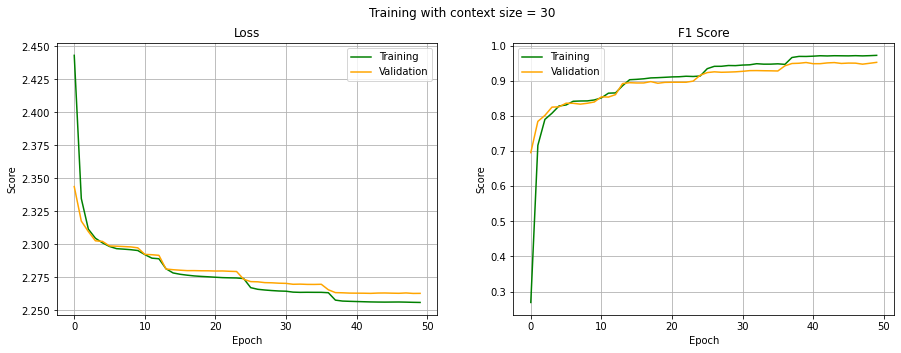

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9724, device='cuda:0'),
 tensor(0.9502, device='cuda:0'),
 tensor(0.9489, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9724, device='cuda:0'),
 tensor(0.9502, device='cuda:0'),
 tensor(0.9489, device='cuda:0'))

## Heatmap

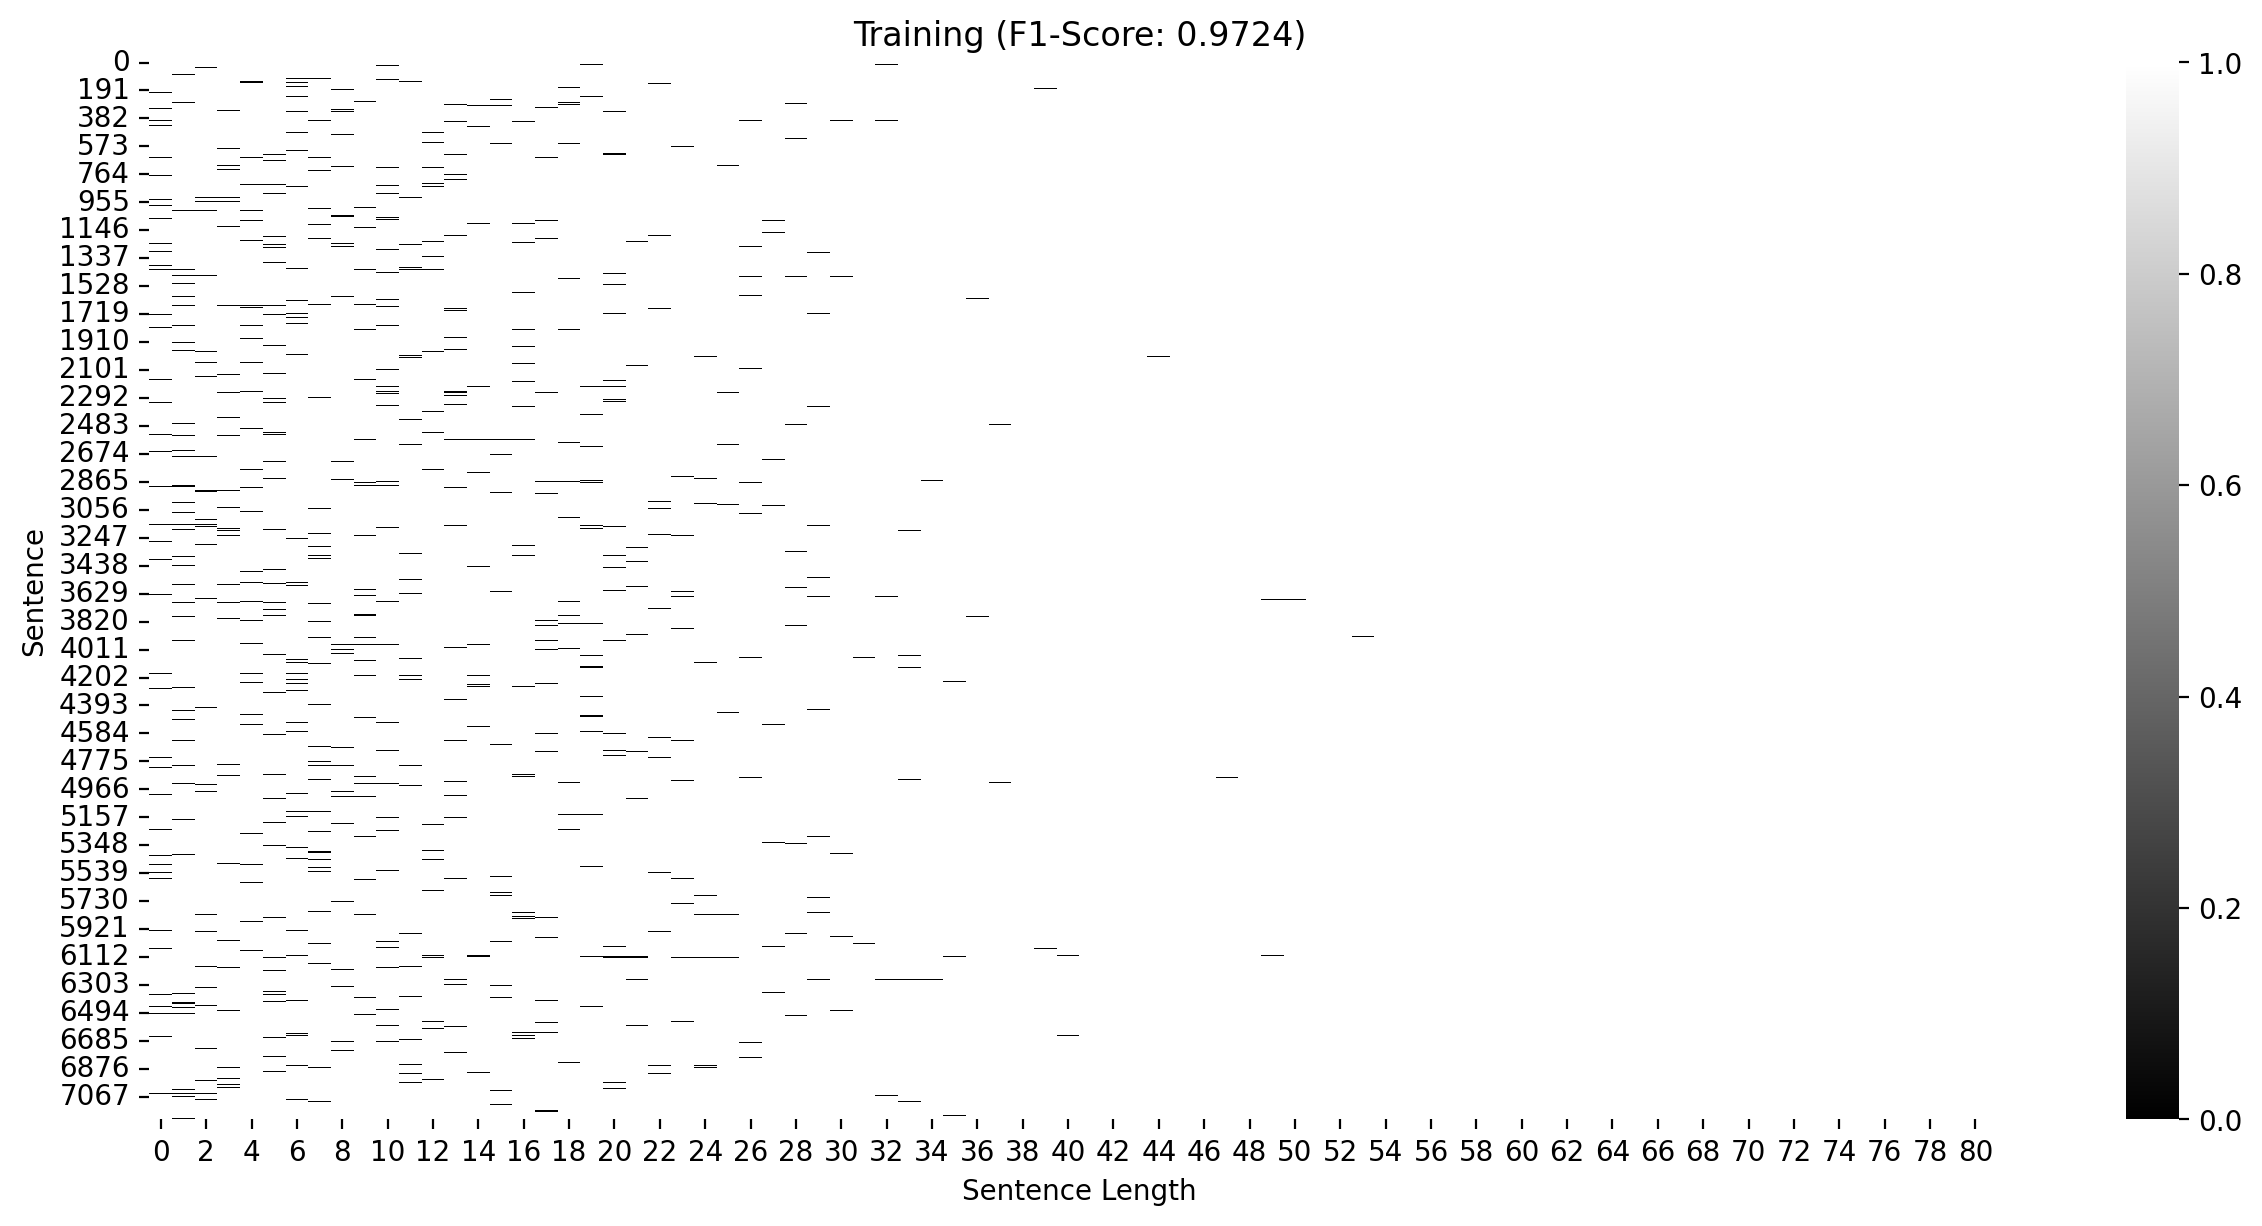

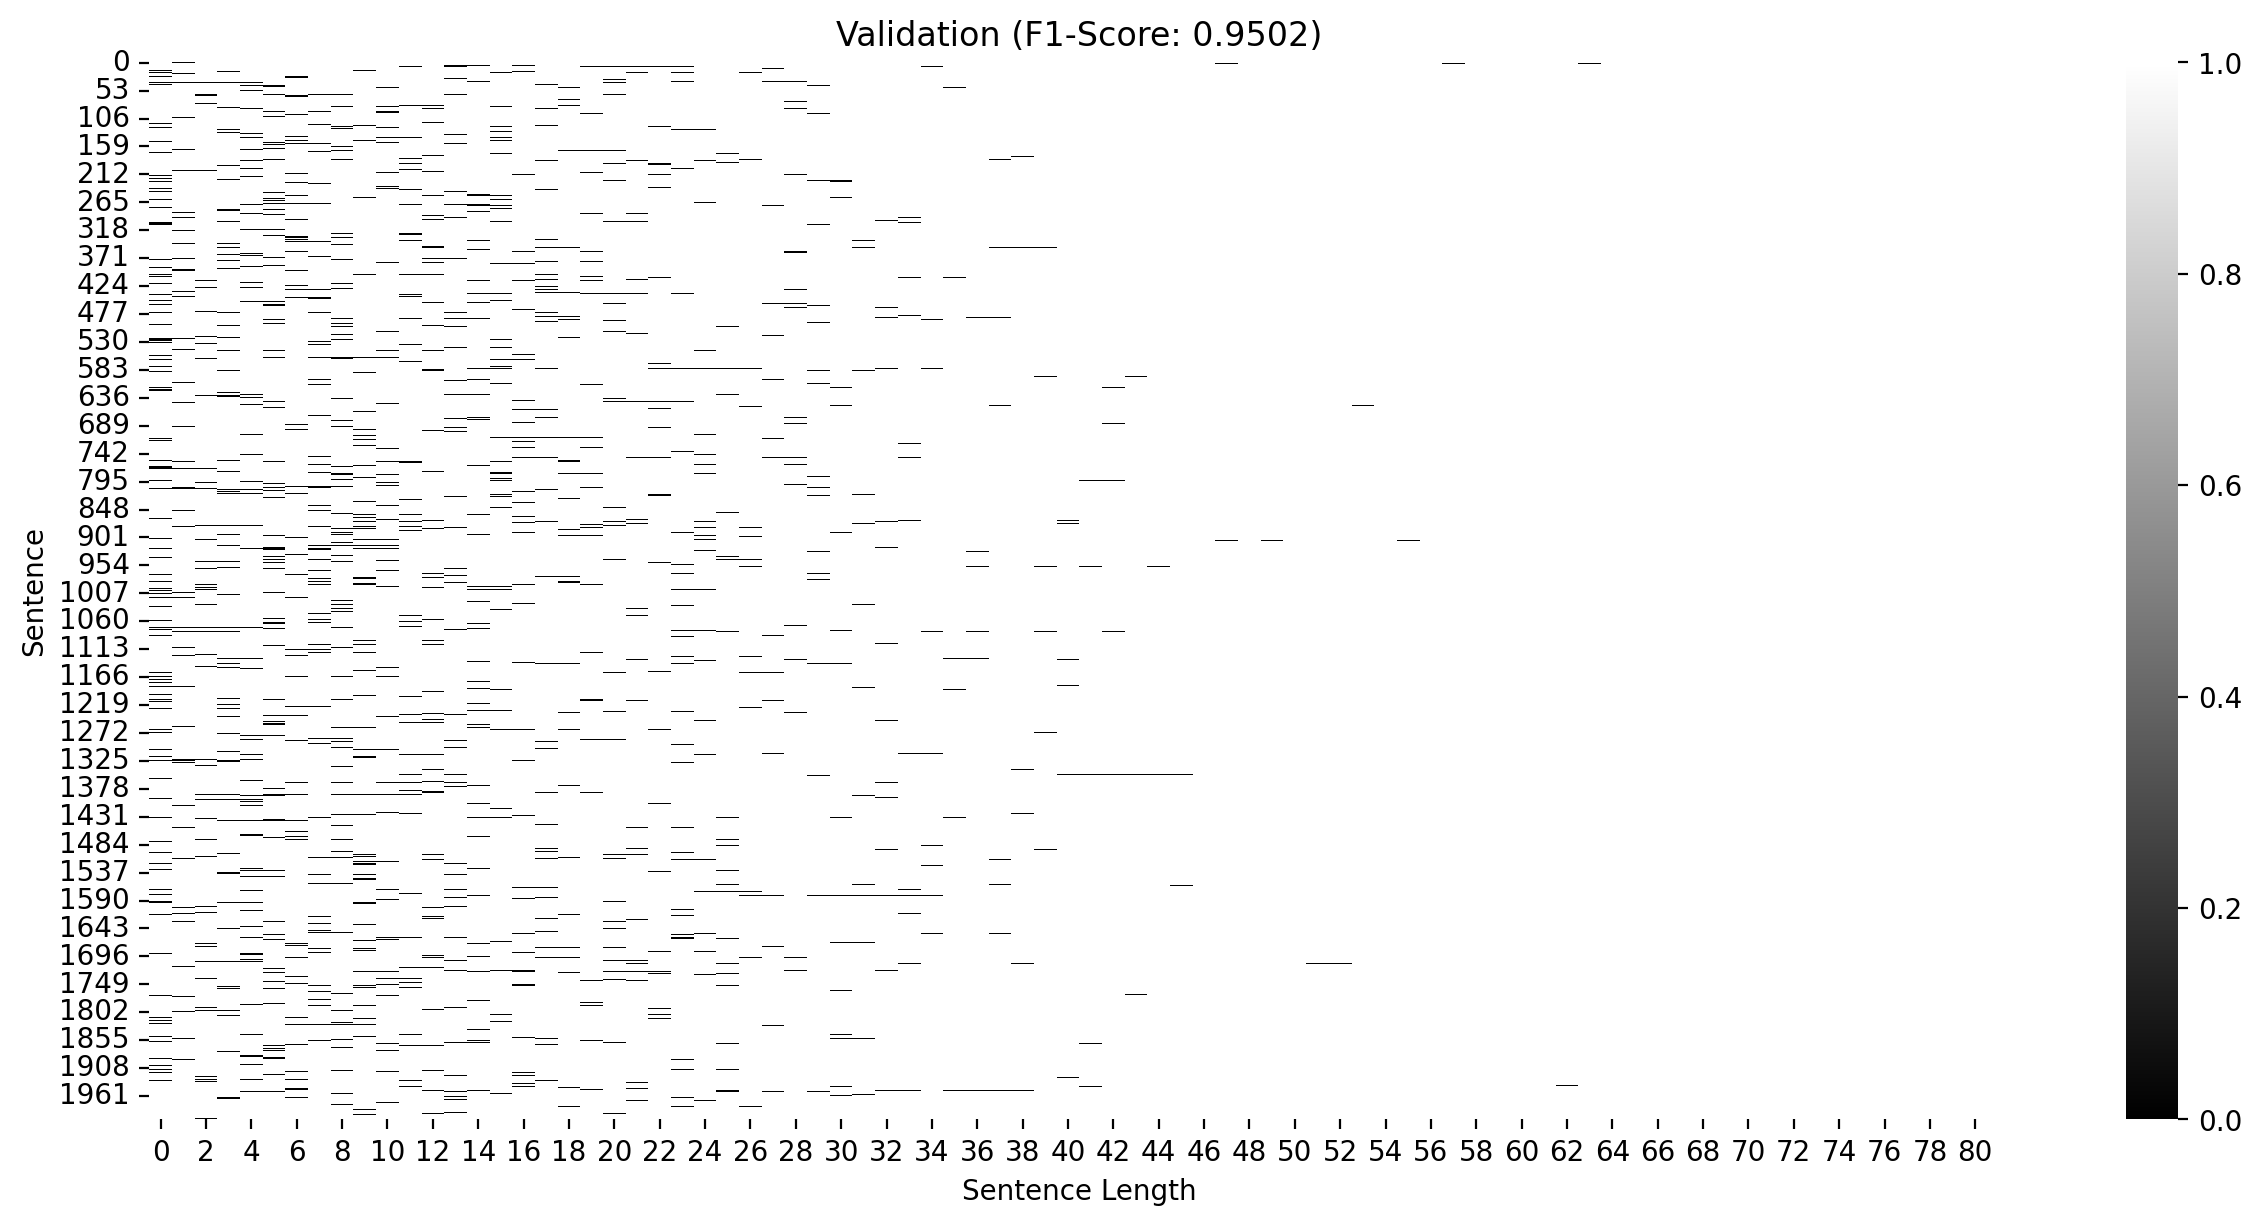

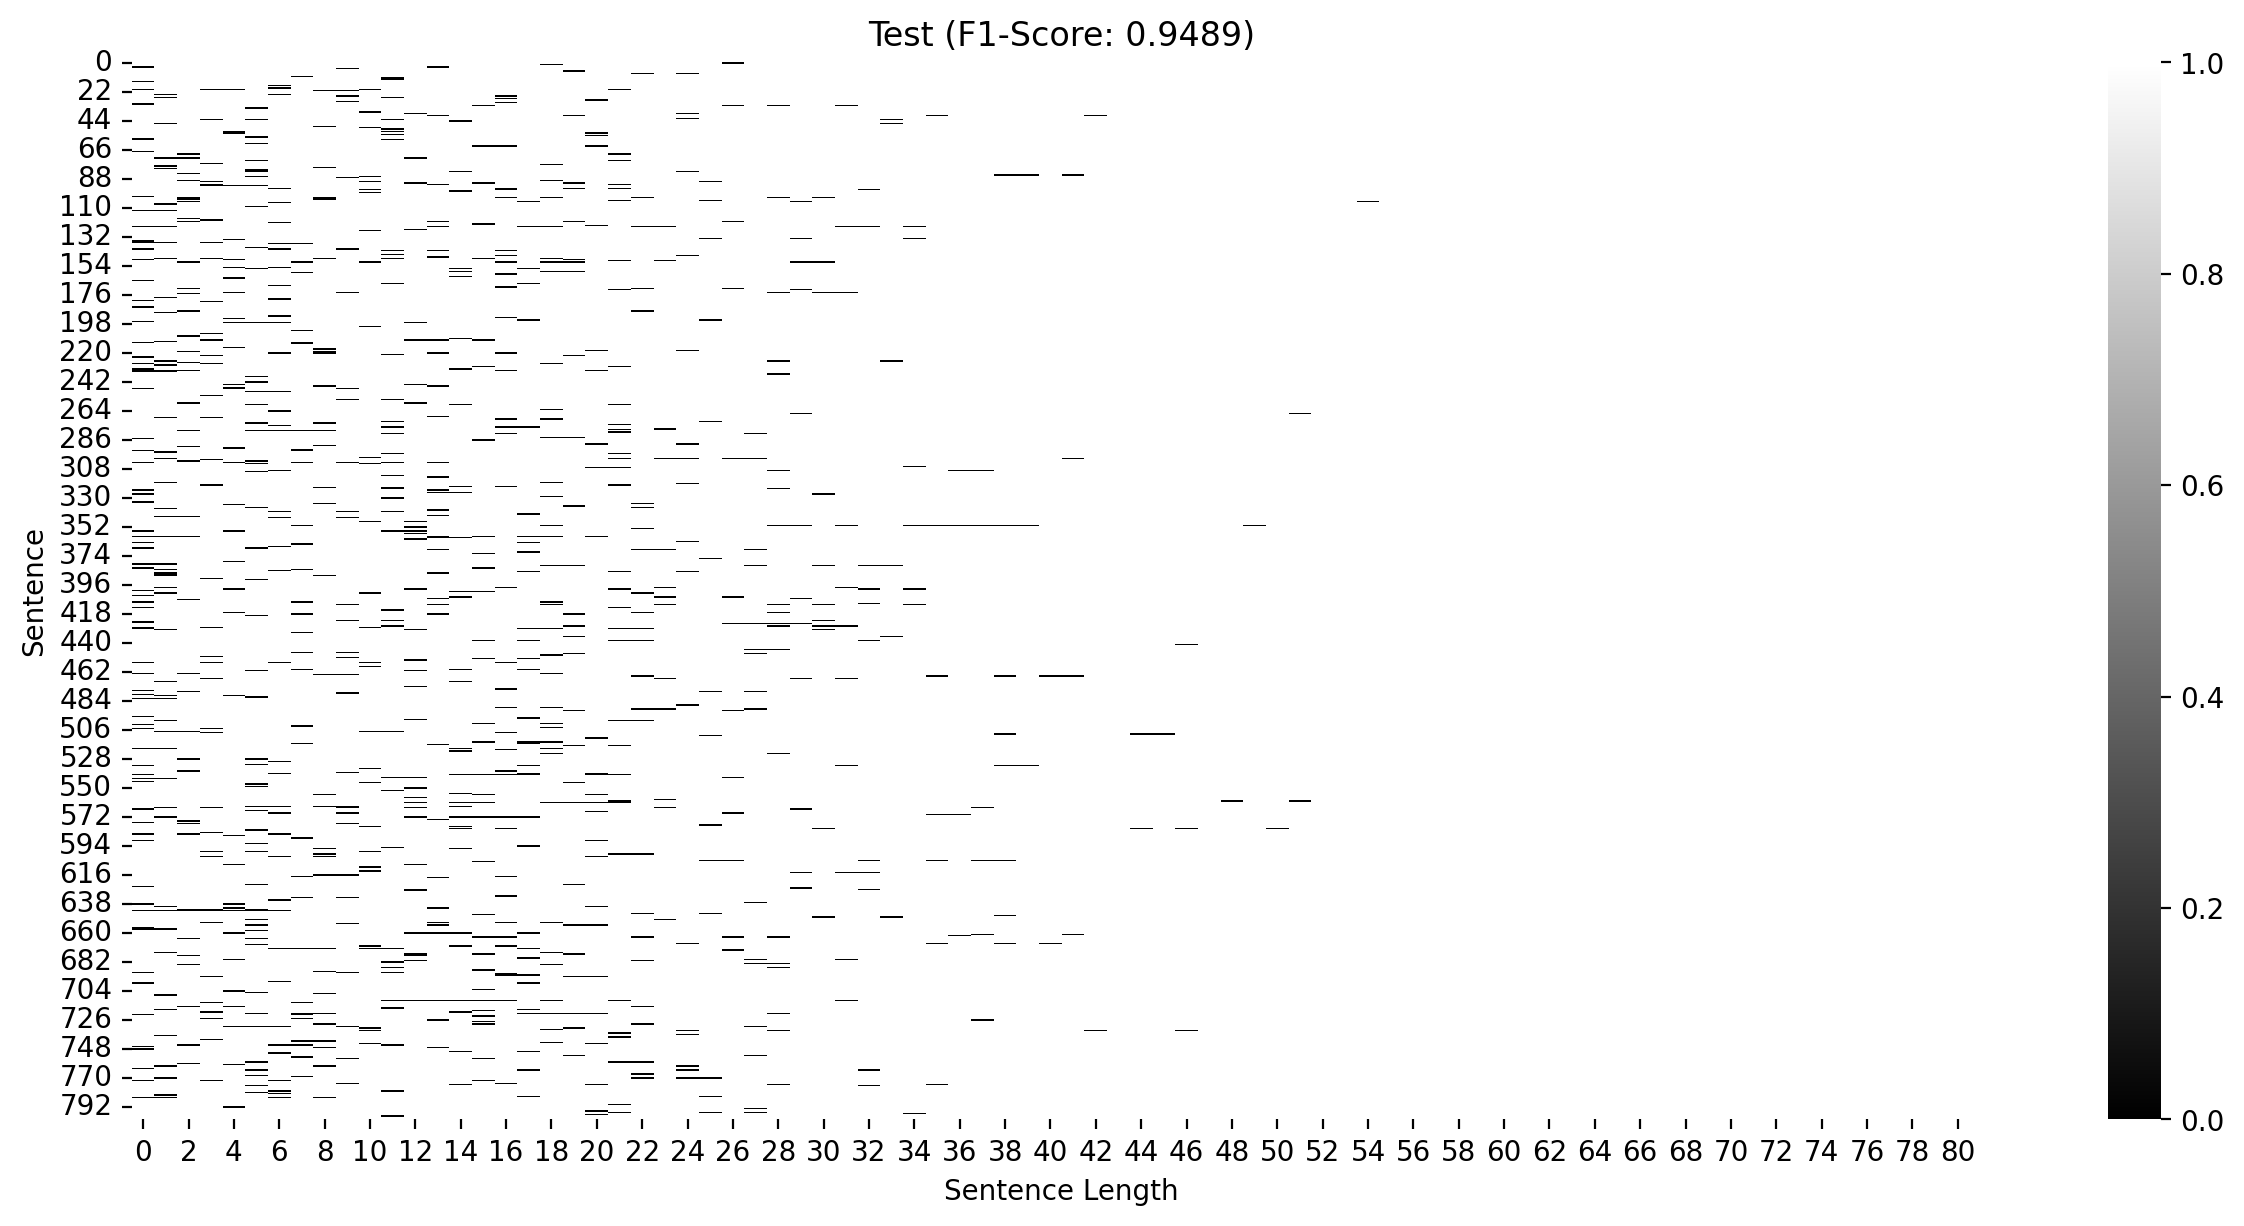

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


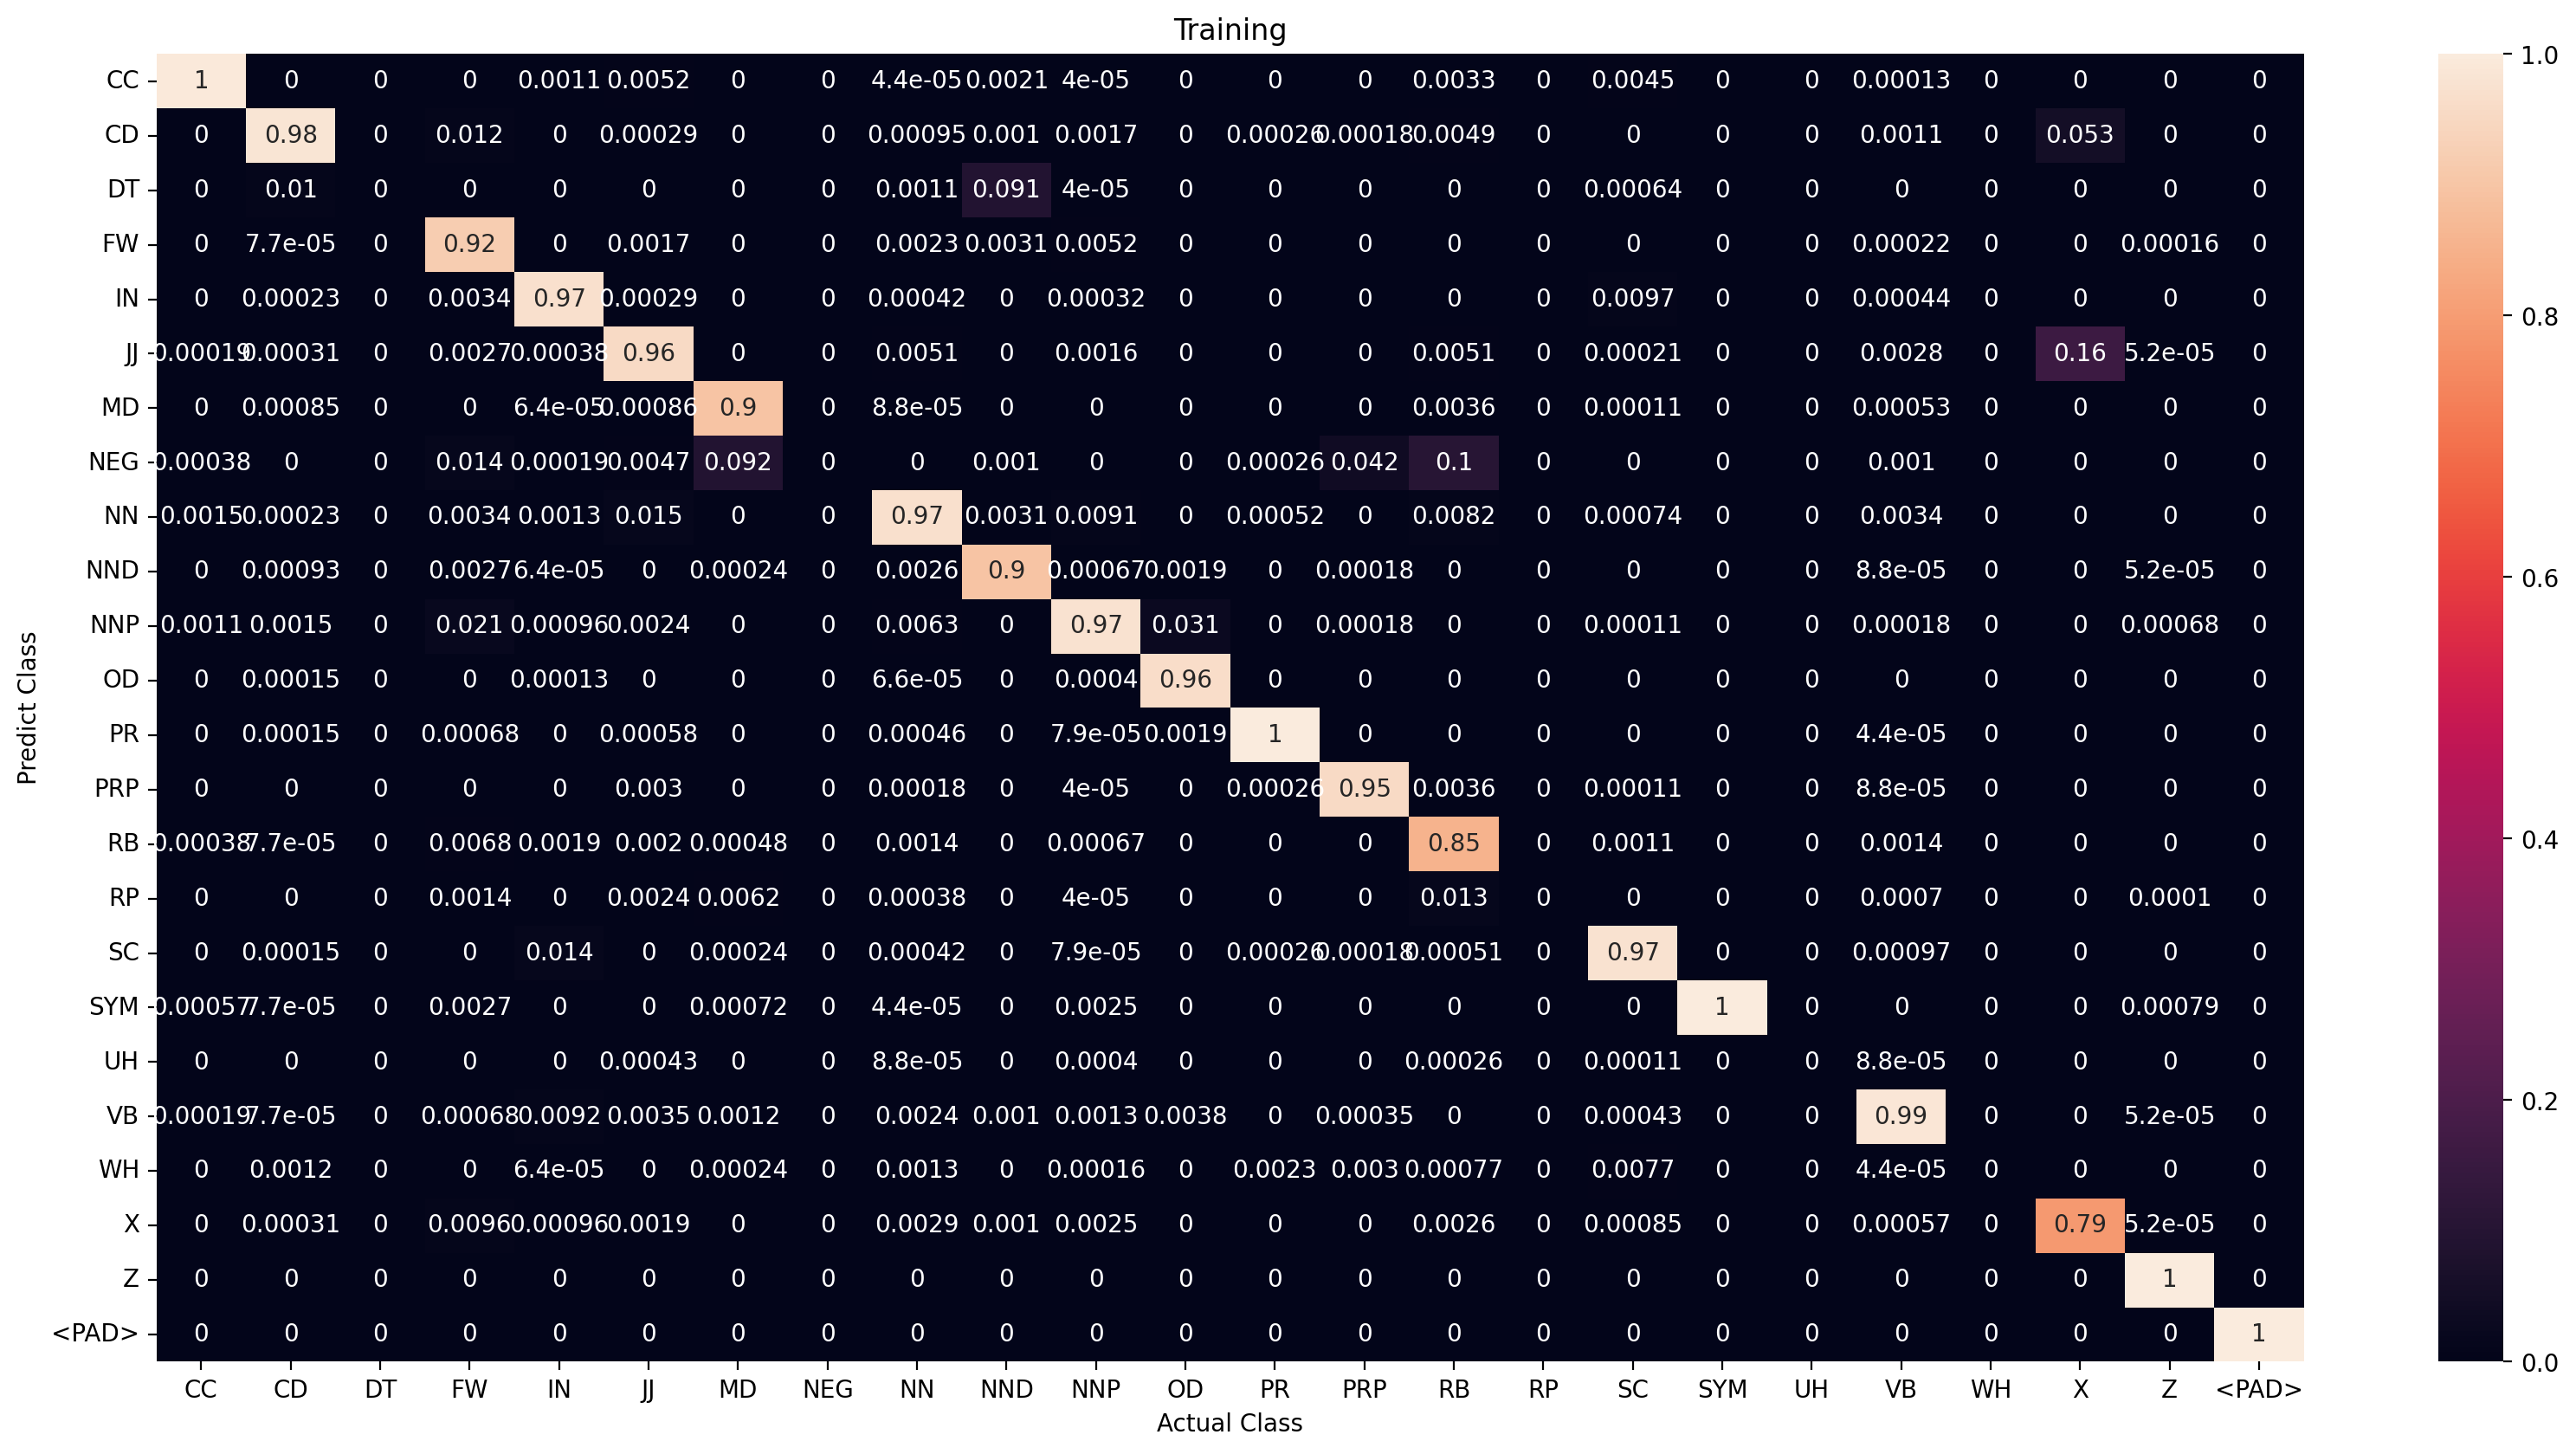

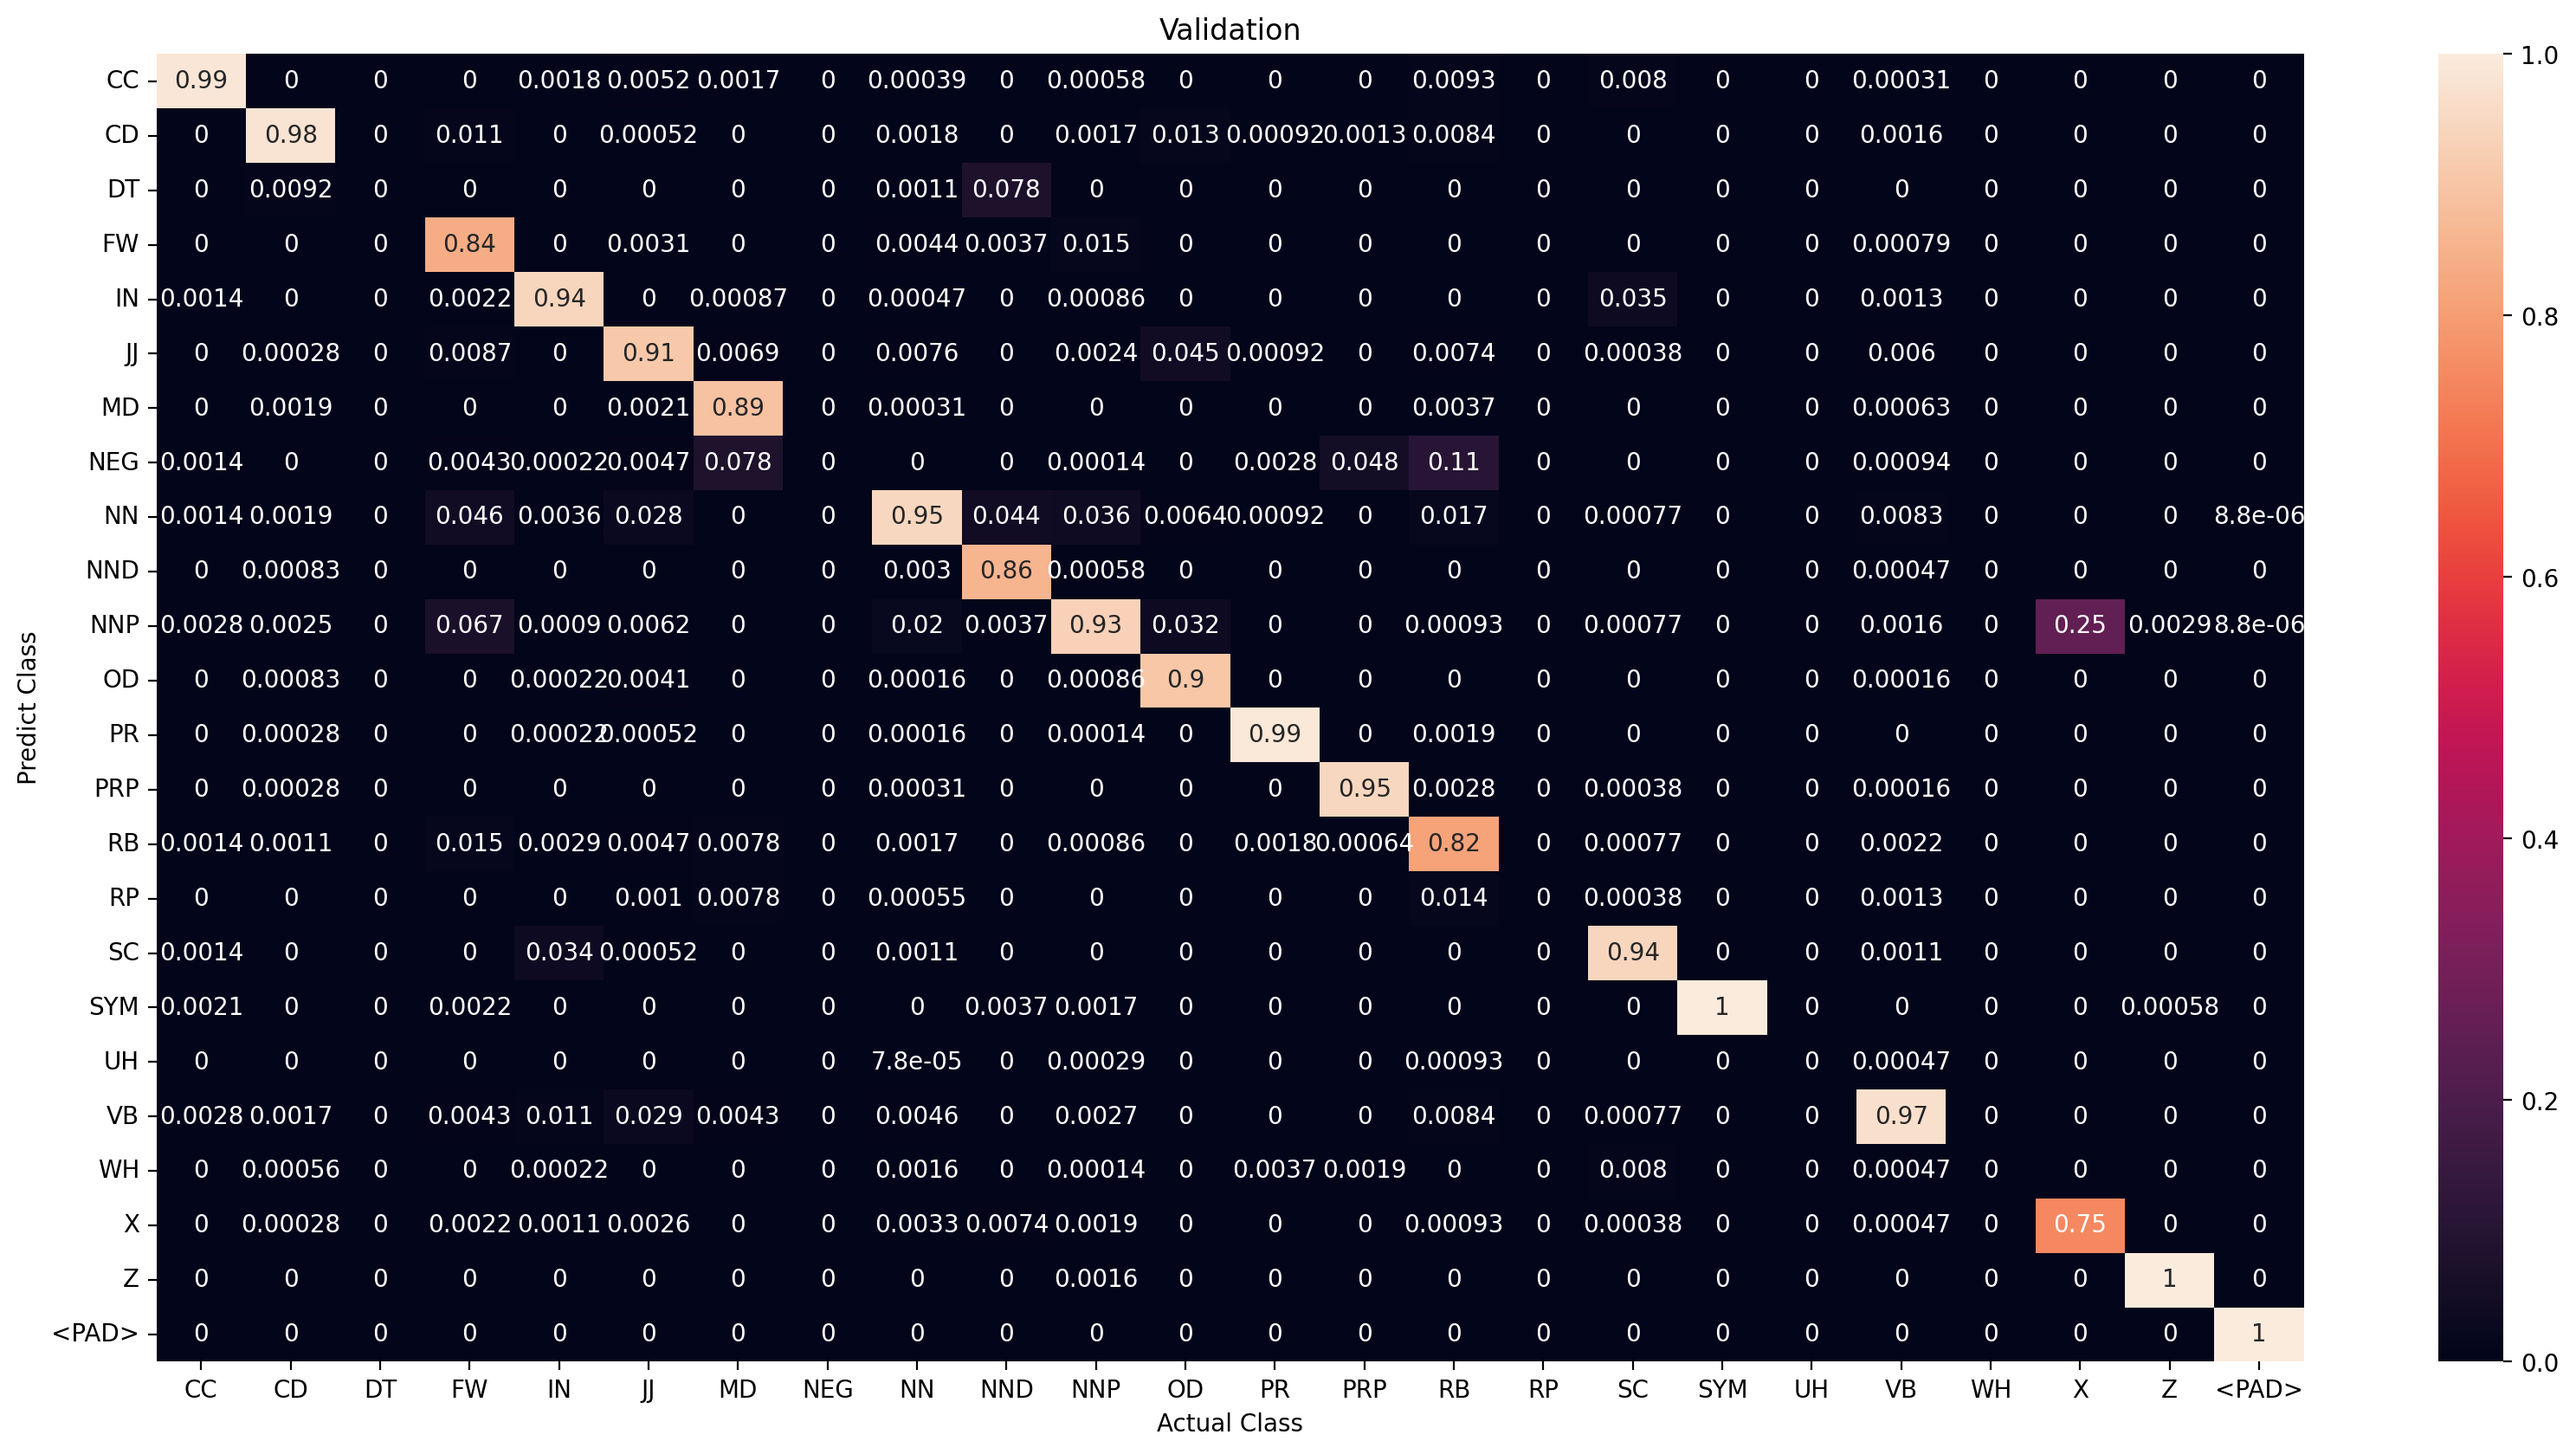

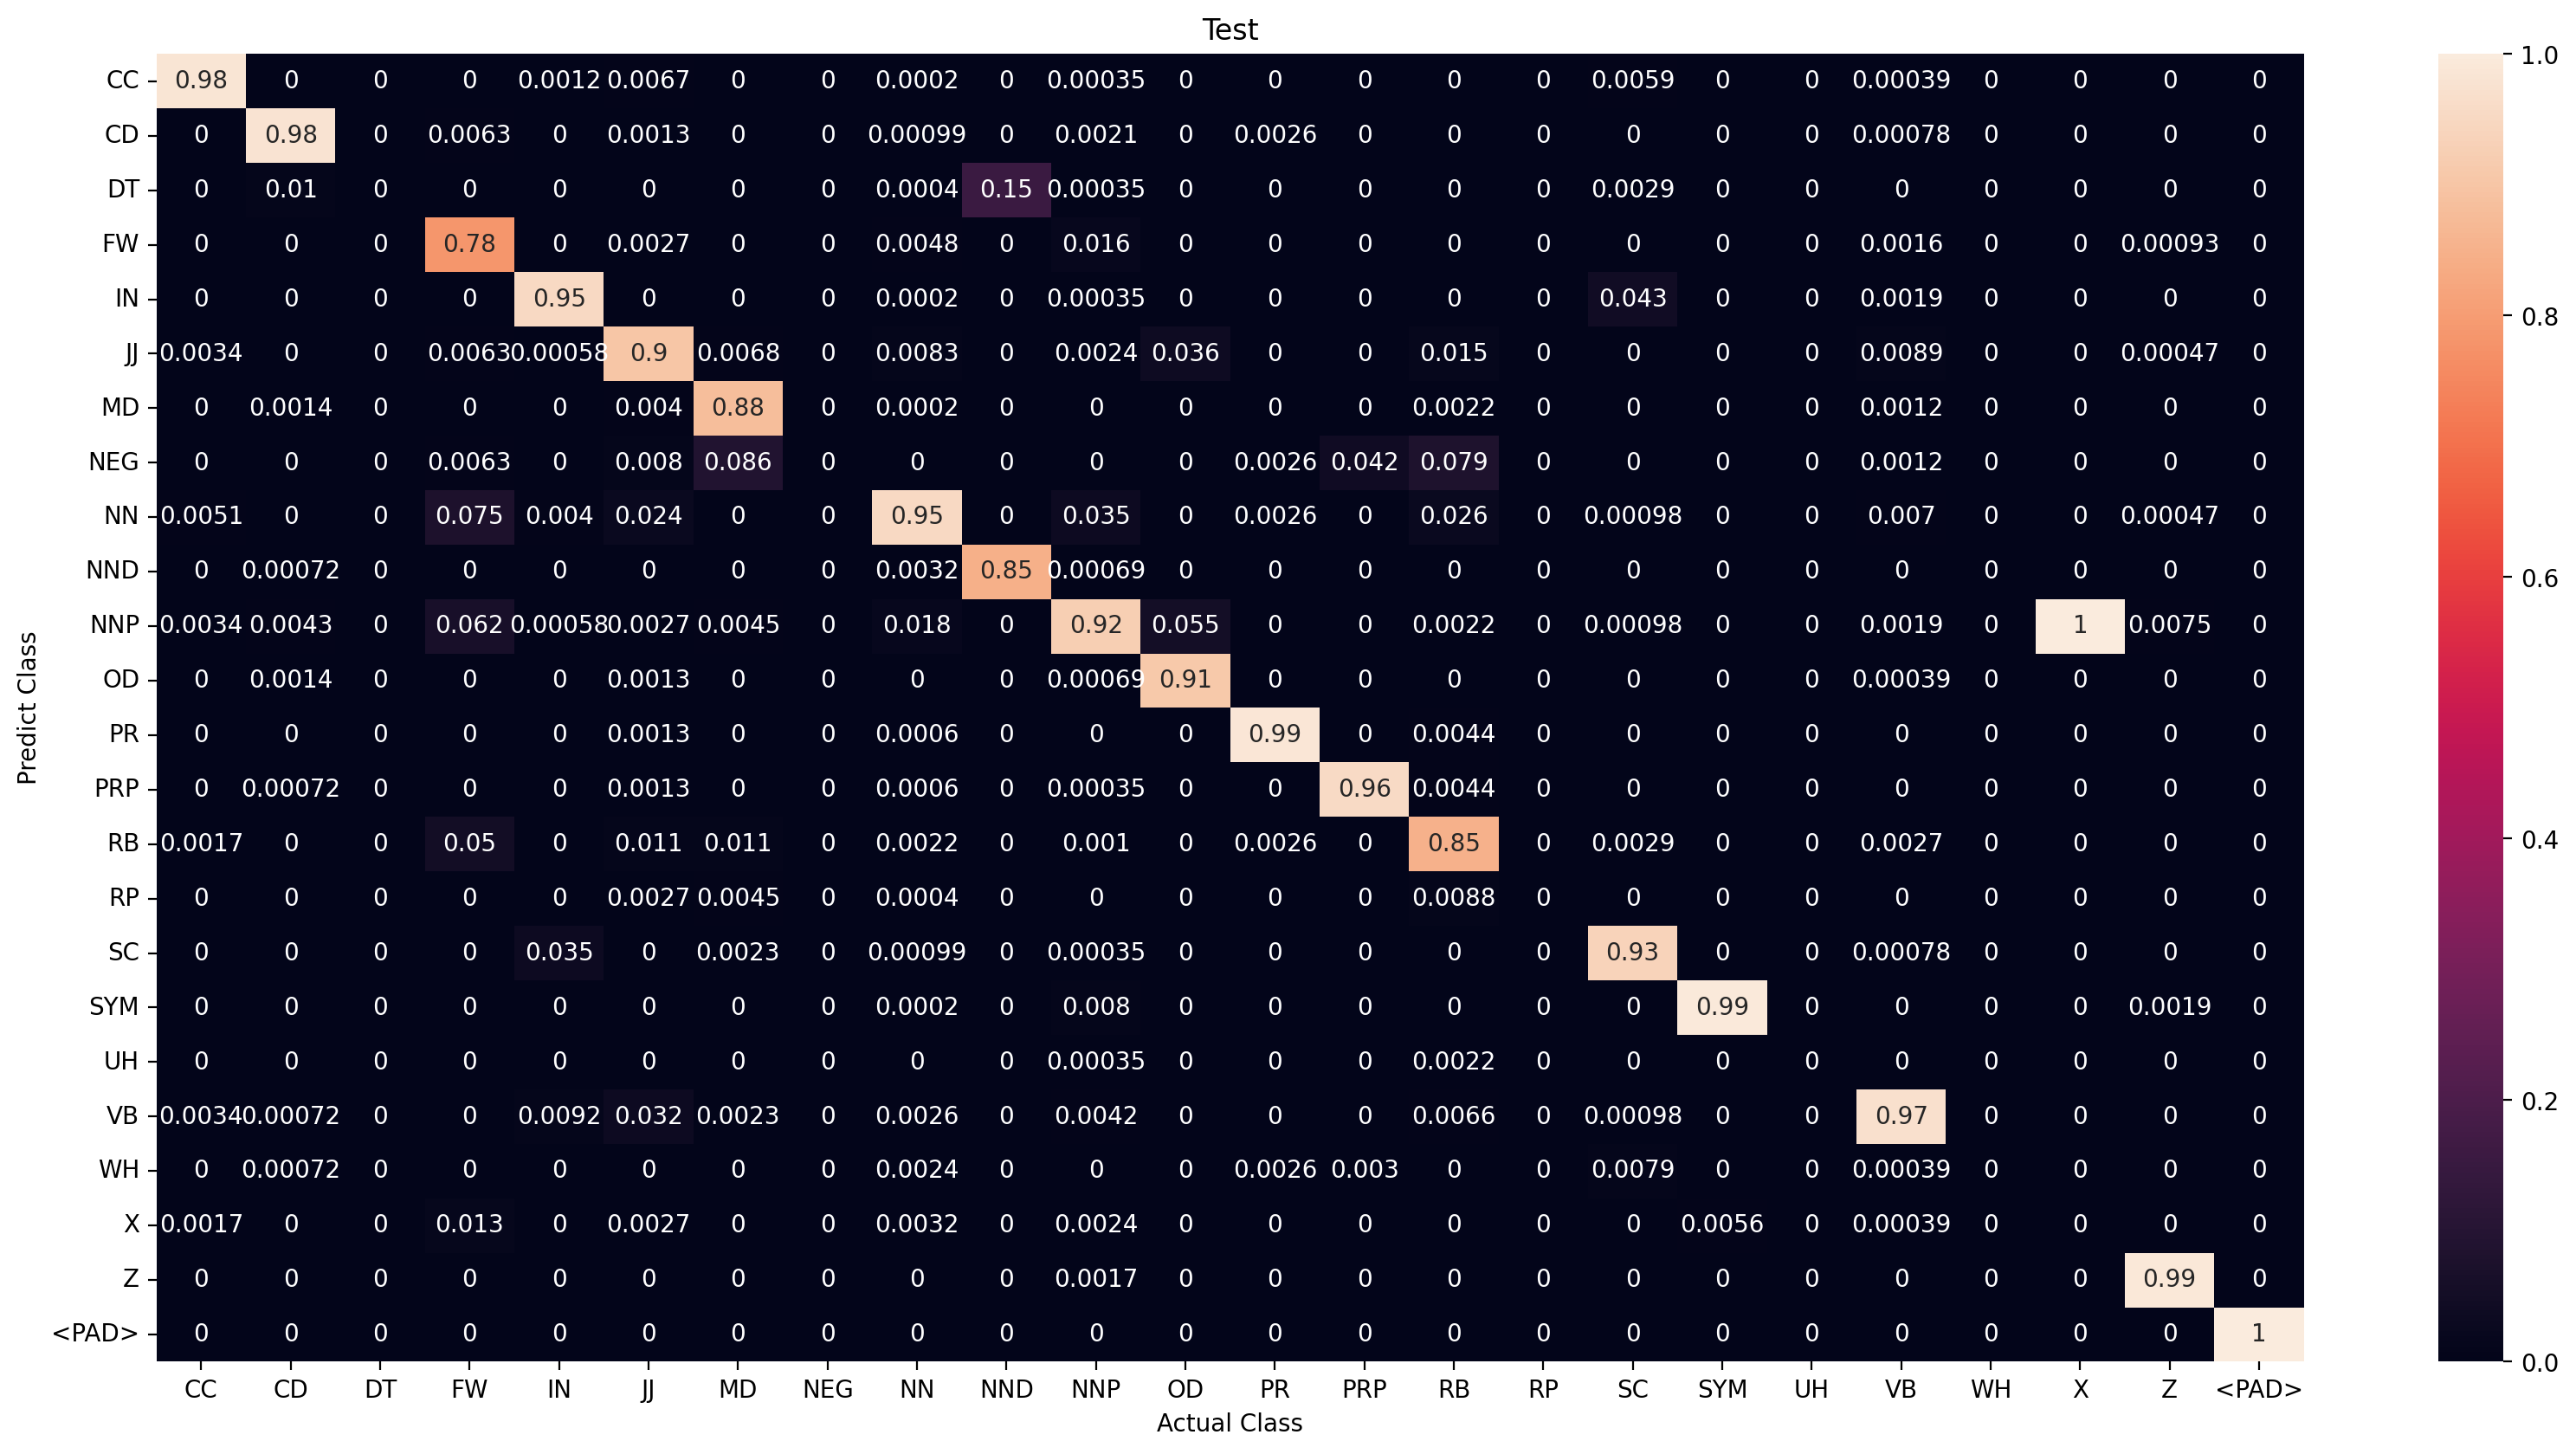

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5281       | CC    : 116      |
| CD    : 12862  | CD    : 12710      | CD    : 152      |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1344       | FW    : 261      |
| IN    : 15290  | IN    : 15152      | IN    : 138      |
| JJ    : 7025   | JJ    : 6648       | JJ    : 377      |
| MD    : 3798   | MD    : 3749       | MD    : 49       |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43981      | NN    : 491      |
| NND   : 1033   | NND   : 874        | NND   : 159      |
| NNP   : 25007  | NNP   : 24601      | NNP   : 406      |
| OD    : 519    | OD    : 502        | OD    : 17       |
| PR    : 3880   | PR    : 3848       | PR    : 32       |
| PRP   : 5449   | PRP   : 5401       | PRP   : 48       |
| RB    : 3502   | RB    : 3322       | RB    : 180      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11189
Wrong prediction            : 782
Percentage correct oov pred : 93.46754657087962

Validation
Number OOV token            : 3190
Correct prediction          : 2837
Wrong prediction            : 353
Percentage correct oov pred : 88.93416927899686

Test
Number OOV token            : 1401
Correct prediction          : 1246
Wrong prediction            : 155
Percentage correct oov pred : 88.93647394718059



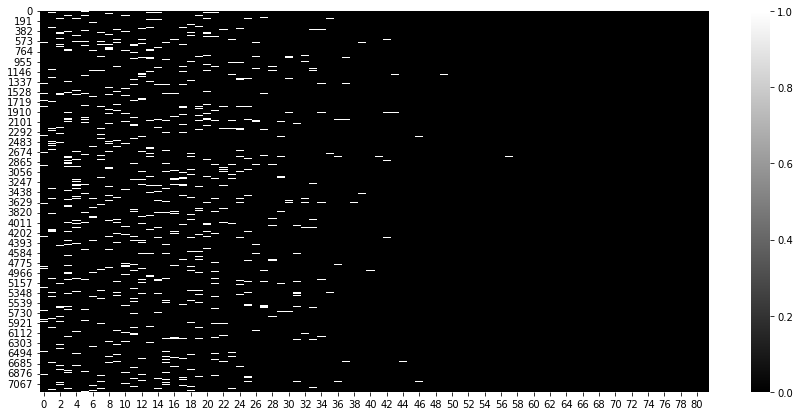

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

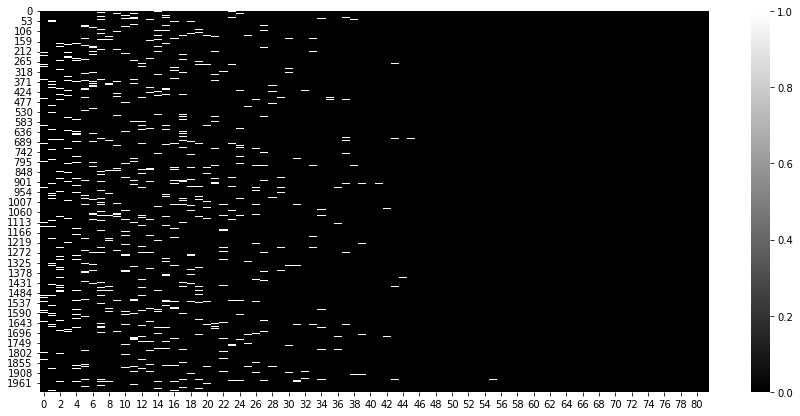

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

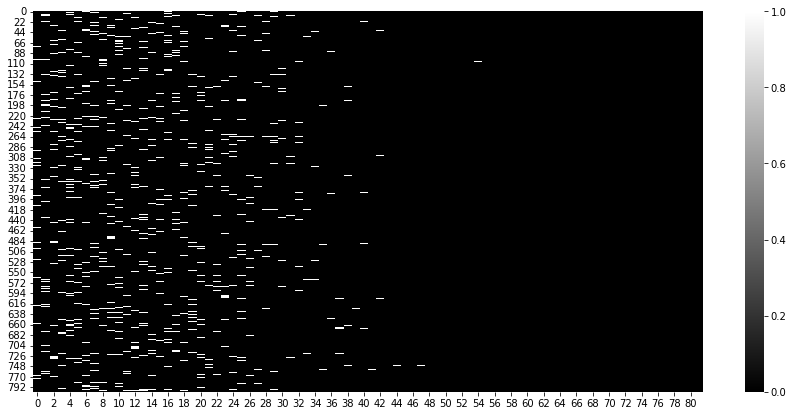

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);